In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Test_path = '/content/drive/My Drive/DataSet_Work/Anaconda1/Train'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load and augment data from Google Drive
train_generator = train_datagen.flow_from_directory(
    Test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
print(train_generator.class_indices)

Found 3013 images belonging to 2 classes.
{'aspam': 0, 'ham': 1}


In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define the DenseNet-like model
def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)
    return conv_x

def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate
    return block_x, filters

def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)
    return trans_x, tran_filters

def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(224, 224, 3))  # Adjusted input shape to match typical image size
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)
    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(dense_x)
    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)

    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    # Output layer for binary classification
    output = Dense(classes, activation='sigmoid')(dense_x)

    return Model(input_img, output)

# Create the DenseNet-like model
filters = 24  # Initial number of filters
growth_rate = 12  # Growth rate for DenseNet blocks
classes = 2  # Number of output classes (2 for binary classification: ham and spam)
dense_block_size = 4  # Number of dense blocks
layers_in_block = 3  # Number of layers in each dense block

model = dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 24)         648       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 24)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 24)         0         ['batch_normalization[0][0

In [ ]:
# Generate dummy data (replace with actual data loading/preprocessing)
X = np.random.randn(100, 224, 224, 3)  # Example: 100 images of size 224x224x3
y = np.random.randint(0, 2, size=100)  # Example: Binary labels (0 or 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Convert labels to categorical format
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Train the model
history = model.fit(X_train, y_train_cat, batch_size=7, epochs=100, validation_data=(X_test, y_test_cat))

Epoch 1/100
10/10 [==============================] - 22s 2s/step - loss: 1.5646 - accuracy: 0.5075 - val_loss: 42.7297 - val_accuracy: 0.4545
Epoch 2/100
10/10 [==============================] - 18s 2s/step - loss: 0.5376 - accuracy: 0.7612 - val_loss: 48.2085 - val_accuracy: 0.4545
Epoch 3/100
10/10 [==============================] - 18s 2s/step - loss: 0.2835 - accuracy: 0.9104 - val_loss: 24.9185 - val_accuracy: 0.4545
Epoch 4/100
10/10 [==============================] - 18s 2s/step - loss: 0.1947 - accuracy: 0.9552 - val_loss: 5.7331 - val_accuracy: 0.4545
Epoch 5/100
10/10 [==============================] - 18s 2s/step - loss: 0.0650 - accuracy: 1.0000 - val_loss: 1.6456 - val_accuracy: 0.4242
Epoch 6/100
10/10 [==============================] - 19s 2s/step - loss: 0.0852 - accuracy: 0.9701 - val_loss: 3.3202 - val_accuracy: 0.5455
Epoch 7/100
10/10 [==============================] - 19s 2s/step - loss: 0.0494 - accuracy: 1.0000 - val_loss: 1.2538 - val_accuracy: 0.5455
Epoch 8/10

2/2 [==============================] - 3s 81ms/step - loss: 0.8705 - accuracy: 0.4545
Test loss: 0.8705
Test accuracy: 0.4545
2/2 [==============================] - 2s 48ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.45      1.00      0.62        15

    accuracy                           0.45        33
   macro avg       0.23      0.50      0.31        33
weighted avg       0.21      0.45      0.28        33



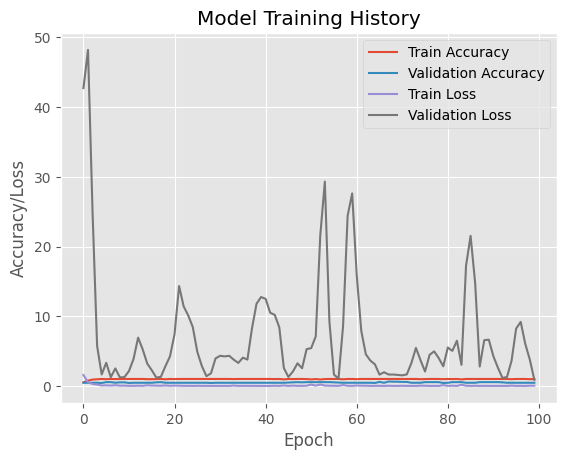

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib

# Set ggplot style
matplotlib.style.use('ggplot')

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Generate predictions
label_pred = model.predict(X_test)

# Convert predictions to class labels (if needed)
pred = np.argmax(label_pred, axis=1)

# Convert one-hot encoded true labels to index (if needed)
Y_test = np.argmax(y_test_cat, axis=1)

# Print classification report
print(classification_report(Y_test, pred))

# Plot training history
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.savefig('training_history.png')
plt.show()
